### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [1]:
# # Import libraries for importing files from Google drive to Colab
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authorize Google SDK to access Google Drive from Colab

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [2]:
# download = drive.CreateFile({'id': '請自行輸入自己上傳google drive檔案的連結id'})
# download.GetContentFile('ptb.train.txt')

### Import Necessary Libraries

In [3]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
# 讀取資料

# Penn Tree Back dataset
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [5]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [6]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            
            if self.only_word:
                sentence = [word.lower() for word in sentence if word.isalpha()]
            else:
                punctuation_list = ['.', ',', '!', '?']
                sentence = ' '.join(sentence).lower()
                for pun in punctuation_list:
                    sentence = sentence.replace(pun, ' '+pun)
                sentence = sentence.split(' ')
            
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys())}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum(len(line) for line in self.processed_corpus)
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        p = self.t / (self.word_frequency[self.idx2word[idx]] / self.total_num_words)
        p_w = np.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 796633 words
After subsampling: 407183 words


### 定義Skip-gram使用的Dataset與collate function

In [7]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # 返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            all_contexts += [[word] for word in line[self.window_size:-self.window_size]]
            for index in range(self.window_size, len(line) - self.window_size):
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_targets.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in cur_exists_words]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for targets in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:  
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=100000)
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                if neg_candidate[i] != targets:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)
                
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        contexts += [context]
        target_negative += [target + negative]
        labels += [[1]*len(target) + [0]*len(negative)]
        
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [8]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts).squeeze()
        u = self.out_embedding(targets)

        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 訓練

In [9]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 2, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [10]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Loss: 2.98453


  1%|▊                                                                                 | 1/100 [00:02<04:16,  2.59s/it]

Epoch: 2/100, Loss: 1.26890


  2%|█▋                                                                                | 2/100 [00:04<04:03,  2.48s/it]

Epoch: 3/100, Loss: 0.75842


  3%|██▍                                                                               | 3/100 [00:07<03:52,  2.40s/it]

Epoch: 4/100, Loss: 0.58117


  4%|███▎                                                                              | 4/100 [00:09<03:50,  2.40s/it]

Epoch: 5/100, Loss: 0.50420


  5%|████                                                                              | 5/100 [00:11<03:44,  2.37s/it]

Epoch: 6/100, Loss: 0.46016


  6%|████▉                                                                             | 6/100 [00:14<03:41,  2.36s/it]

Epoch: 7/100, Loss: 0.42929


  7%|█████▋                                                                            | 7/100 [00:16<03:34,  2.31s/it]

Epoch: 8/100, Loss: 0.40479


  8%|██████▌                                                                           | 8/100 [00:18<03:31,  2.30s/it]

Epoch: 9/100, Loss: 0.38463


  9%|███████▍                                                                          | 9/100 [00:20<03:28,  2.29s/it]

Epoch: 10/100, Loss: 0.36743


 10%|████████                                                                         | 10/100 [00:22<03:23,  2.26s/it]

Epoch: 11/100, Loss: 0.35281


 11%|████████▉                                                                        | 11/100 [00:25<03:20,  2.25s/it]

Epoch: 12/100, Loss: 0.34015


 12%|█████████▋                                                                       | 12/100 [00:27<03:17,  2.24s/it]

Epoch: 13/100, Loss: 0.32906


 13%|██████████▌                                                                      | 13/100 [00:29<03:21,  2.31s/it]

Epoch: 14/100, Loss: 0.31935


 14%|███████████▎                                                                     | 14/100 [00:32<03:19,  2.32s/it]

Epoch: 15/100, Loss: 0.31106


 15%|████████████▏                                                                    | 15/100 [00:34<03:13,  2.28s/it]

Epoch: 16/100, Loss: 0.30377


 16%|████████████▉                                                                    | 16/100 [00:36<03:08,  2.24s/it]

Epoch: 17/100, Loss: 0.29755


 17%|█████████████▊                                                                   | 17/100 [00:38<03:07,  2.26s/it]

Epoch: 18/100, Loss: 0.29202


 18%|██████████████▌                                                                  | 18/100 [00:41<03:05,  2.26s/it]

Epoch: 19/100, Loss: 0.28705


 19%|███████████████▍                                                                 | 19/100 [00:43<03:00,  2.23s/it]

Epoch: 20/100, Loss: 0.28260


 20%|████████████████▏                                                                | 20/100 [00:45<02:57,  2.22s/it]

Epoch: 21/100, Loss: 0.27851


 21%|█████████████████                                                                | 21/100 [00:47<02:56,  2.23s/it]

Epoch: 22/100, Loss: 0.27527


 22%|█████████████████▊                                                               | 22/100 [00:50<02:55,  2.25s/it]

Epoch: 23/100, Loss: 0.27228


 23%|██████████████████▋                                                              | 23/100 [00:52<02:51,  2.23s/it]

Epoch: 24/100, Loss: 0.26932


 24%|███████████████████▍                                                             | 24/100 [00:54<02:50,  2.24s/it]

Epoch: 25/100, Loss: 0.26669


 25%|████████████████████▎                                                            | 25/100 [00:56<02:50,  2.27s/it]

Epoch: 26/100, Loss: 0.26423


 26%|█████████████████████                                                            | 26/100 [00:59<02:47,  2.27s/it]

Epoch: 27/100, Loss: 0.26249


 27%|█████████████████████▊                                                           | 27/100 [01:01<02:45,  2.27s/it]

Epoch: 28/100, Loss: 0.26020


 28%|██████████████████████▋                                                          | 28/100 [01:03<02:40,  2.23s/it]

Epoch: 29/100, Loss: 0.25892


 29%|███████████████████████▍                                                         | 29/100 [01:05<02:37,  2.22s/it]

Epoch: 30/100, Loss: 0.25703


 30%|████████████████████████▎                                                        | 30/100 [01:07<02:34,  2.20s/it]

Epoch: 31/100, Loss: 0.25555


 31%|█████████████████████████                                                        | 31/100 [01:10<02:33,  2.22s/it]

Epoch: 32/100, Loss: 0.25379


 32%|█████████████████████████▉                                                       | 32/100 [01:12<02:31,  2.22s/it]

Epoch: 33/100, Loss: 0.25292


 33%|██████████████████████████▋                                                      | 33/100 [01:14<02:28,  2.22s/it]

Epoch: 34/100, Loss: 0.25203


 34%|███████████████████████████▌                                                     | 34/100 [01:16<02:26,  2.21s/it]

Epoch: 35/100, Loss: 0.25077


 35%|████████████████████████████▎                                                    | 35/100 [01:18<02:22,  2.20s/it]

Epoch: 36/100, Loss: 0.24949


 36%|█████████████████████████████▏                                                   | 36/100 [01:21<02:22,  2.22s/it]

Epoch: 37/100, Loss: 0.24848


 37%|█████████████████████████████▉                                                   | 37/100 [01:23<02:19,  2.21s/it]

Epoch: 38/100, Loss: 0.24784


 38%|██████████████████████████████▊                                                  | 38/100 [01:25<02:16,  2.20s/it]

Epoch: 39/100, Loss: 0.24680


 39%|███████████████████████████████▌                                                 | 39/100 [01:27<02:13,  2.19s/it]

Epoch: 40/100, Loss: 0.24597


 40%|████████████████████████████████▍                                                | 40/100 [01:30<02:13,  2.22s/it]

Epoch: 41/100, Loss: 0.24507


 41%|█████████████████████████████████▏                                               | 41/100 [01:32<02:09,  2.20s/it]

Epoch: 42/100, Loss: 0.24434


 42%|██████████████████████████████████                                               | 42/100 [01:34<02:07,  2.19s/it]

Epoch: 43/100, Loss: 0.24368


 43%|██████████████████████████████████▊                                              | 43/100 [01:36<02:05,  2.20s/it]

Epoch: 44/100, Loss: 0.24317


 44%|███████████████████████████████████▋                                             | 44/100 [01:38<02:03,  2.20s/it]

Epoch: 45/100, Loss: 0.24260


 45%|████████████████████████████████████▍                                            | 45/100 [01:41<02:02,  2.23s/it]

Epoch: 46/100, Loss: 0.24158


 46%|█████████████████████████████████████▎                                           | 46/100 [01:43<02:00,  2.22s/it]

Epoch: 47/100, Loss: 0.24167


 47%|██████████████████████████████████████                                           | 47/100 [01:45<01:57,  2.21s/it]

Epoch: 48/100, Loss: 0.24028


 48%|██████████████████████████████████████▉                                          | 48/100 [01:47<01:54,  2.21s/it]

Epoch: 49/100, Loss: 0.24073


 49%|███████████████████████████████████████▋                                         | 49/100 [01:49<01:53,  2.23s/it]

Epoch: 50/100, Loss: 0.23998


 50%|████████████████████████████████████████▌                                        | 50/100 [01:52<01:51,  2.22s/it]

Epoch: 51/100, Loss: 0.23937


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:54<01:48,  2.21s/it]

Epoch: 52/100, Loss: 0.23907


 52%|██████████████████████████████████████████                                       | 52/100 [01:56<01:45,  2.20s/it]

Epoch: 53/100, Loss: 0.23847


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:58<01:43,  2.19s/it]

Epoch: 54/100, Loss: 0.23821


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:01<01:42,  2.23s/it]

Epoch: 55/100, Loss: 0.23755


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:03<01:39,  2.21s/it]

Epoch: 56/100, Loss: 0.23737


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:05<01:36,  2.20s/it]

Epoch: 57/100, Loss: 0.23677


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:07<01:34,  2.20s/it]

Epoch: 58/100, Loss: 0.23668


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:09<01:33,  2.23s/it]

Epoch: 59/100, Loss: 0.23644


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:12<01:30,  2.21s/it]

Epoch: 60/100, Loss: 0.23595


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:14<01:27,  2.20s/it]

Epoch: 61/100, Loss: 0.23537


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:16<01:25,  2.19s/it]

Epoch: 62/100, Loss: 0.23531


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:18<01:23,  2.20s/it]

Epoch: 63/100, Loss: 0.23534


 63%|███████████████████████████████████████████████████                              | 63/100 [02:20<01:22,  2.22s/it]

Epoch: 64/100, Loss: 0.23455


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:23<01:19,  2.20s/it]

Epoch: 65/100, Loss: 0.23435


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:25<01:16,  2.20s/it]

Epoch: 66/100, Loss: 0.23416


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [02:27<01:14,  2.20s/it]

Epoch: 67/100, Loss: 0.23392


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [02:29<01:13,  2.22s/it]

Epoch: 68/100, Loss: 0.23346


 68%|███████████████████████████████████████████████████████                          | 68/100 [02:31<01:10,  2.20s/it]

Epoch: 69/100, Loss: 0.23301


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [02:34<01:08,  2.20s/it]

Epoch: 70/100, Loss: 0.23317


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [02:36<01:06,  2.20s/it]

Epoch: 71/100, Loss: 0.23271


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:38<01:03,  2.19s/it]

Epoch: 72/100, Loss: 0.23295


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [02:40<01:02,  2.22s/it]

Epoch: 73/100, Loss: 0.23223


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [02:42<00:59,  2.20s/it]

Epoch: 74/100, Loss: 0.23223


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [02:45<00:57,  2.20s/it]

Epoch: 75/100, Loss: 0.23202


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:47<00:54,  2.18s/it]

Epoch: 76/100, Loss: 0.23190


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:49<00:52,  2.19s/it]

Epoch: 77/100, Loss: 0.23161


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [02:51<00:50,  2.21s/it]

Epoch: 78/100, Loss: 0.23163


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:53<00:48,  2.21s/it]

Epoch: 79/100, Loss: 0.23090


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:56<00:46,  2.20s/it]

Epoch: 80/100, Loss: 0.23117


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:58<00:43,  2.20s/it]

Epoch: 81/100, Loss: 0.23086


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:00<00:42,  2.22s/it]

Epoch: 82/100, Loss: 0.23084


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [03:02<00:39,  2.21s/it]

Epoch: 83/100, Loss: 0.23043


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [03:04<00:37,  2.20s/it]

Epoch: 84/100, Loss: 0.23014


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [03:07<00:35,  2.21s/it]

Epoch: 85/100, Loss: 0.23013


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [03:09<00:32,  2.20s/it]

Epoch: 86/100, Loss: 0.22984


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [03:11<00:31,  2.22s/it]

Epoch: 87/100, Loss: 0.22999


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [03:13<00:29,  2.23s/it]

Epoch: 88/100, Loss: 0.22975


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:15<00:26,  2.23s/it]

Epoch: 89/100, Loss: 0.22957


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [03:18<00:24,  2.21s/it]

Epoch: 90/100, Loss: 0.22903


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [03:20<00:22,  2.24s/it]

Epoch: 91/100, Loss: 0.22929


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [03:22<00:19,  2.22s/it]

Epoch: 92/100, Loss: 0.22920


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [03:24<00:17,  2.20s/it]

Epoch: 93/100, Loss: 0.22877


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [03:26<00:15,  2.19s/it]

Epoch: 94/100, Loss: 0.22930


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [03:29<00:13,  2.19s/it]

Epoch: 95/100, Loss: 0.22869


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [03:31<00:11,  2.21s/it]

Epoch: 96/100, Loss: 0.22890


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [03:33<00:08,  2.21s/it]

Epoch: 97/100, Loss: 0.22825


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [03:35<00:06,  2.20s/it]

Epoch: 98/100, Loss: 0.22853


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [03:37<00:04,  2.19s/it]

Epoch: 99/100, Loss: 0.22807


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [03:40<00:02,  2.22s/it]

Epoch: 100/100, Loss: 0.22811


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


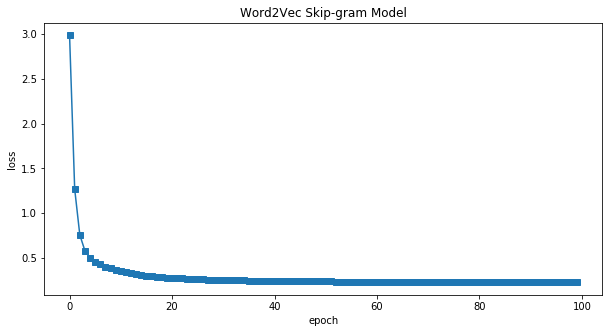

In [11]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [12]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.360: talked.
cosine sim=0.351: signal.
cosine sim=0.343: faster.
cosine sim=0.335: waves.
